# **Model**

Ce notebook se focalise sur la recherche du *meilleur* modèle à retenir pour la mise en production.

La première partie "Préparation de la modélisation" passe en revue les étapes de traitement, en expliquant leur finalité, et en justifiant les choix effectués parmi les options disponibles. Ces choix sont effectués en relation avec les spécificités du jeu de données Home Credit et avec le but prédictif (ici de la classification binaire supervisée avec classes déséquilibrées). Par choix, nous entendons celui des stratégies (et leurs implémentations) retenues et celui de leurs paramètres fixés ou restreints à un sous-domaine à explorer lors du benchmark.

La seconde "Evaluation des modèles" se concentre sur la mise en place du *framework* sur la base duquel nous allons effectuer notre recherche en grille, c'est-à-dire un benchmark de modèles dont on fait varier les hyperparamètres dans les domaines retenus dans la première partie. De ce poin de vue, la première partie est bien une spécification fonctionnelle de la seconde qui en est la réalisation. L'ensemble de ces étapes péparatoires qui interviennent en amont de l'entraînement d'un modèle; l'entraînement du modèle et l'évaluation des performance du modèles, sont intégrées dans une fonction principale `home_credit.best_model_search.kfold_eval_model` qui joue le rôle de *pipeline*.

La dernière partie "Benchmark des modèles" évalue et compare les multiples configurations envisagées en vue de déterminer la plus performante d'entre-elles. L'enjeu est ici de bien définir, objectivement, ce que l'on entend par performance. La performance objective a de nombreuses facettes, parfois contradictoires (corrélées négativement). En gagnant d'un côté, on peut perdre de l'autre. Mais pour simplifier, on distingura principalement les performances métier, synthétisée dans une fonction de coût objective qu'il s'agit de minimiser (on pourra ici entendre coût pour l'entreprise), et les performances techniques qui se déclinent spatialement (la quantité de ressources mobilisées, notamment la mémoire) et temporellement (la vélocité de l'exécution).

# Préparation de la modélisation

## Chargement des données pré-traitées

In [2]:
from home_credit.load import load_prep_dataset
data = load_prep_dataset("baseline_v1")
display(data)

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,CC_NAME_CONTRACT_STATUS_Sent_proposal_MIN_nan,CC_NAME_CONTRACT_STATUS_Sent_proposal_MAX_False,CC_NAME_CONTRACT_STATUS_Sent_proposal_MAX_True,CC_NAME_CONTRACT_STATUS_Sent_proposal_MAX_nan,CC_NAME_CONTRACT_STATUS_Signed_MIN_False,CC_NAME_CONTRACT_STATUS_Signed_MIN_True,CC_NAME_CONTRACT_STATUS_Signed_MIN_nan,CC_NAME_CONTRACT_STATUS_Signed_MAX_False,CC_NAME_CONTRACT_STATUS_Signed_MAX_True,CC_NAME_CONTRACT_STATUS_Signed_MAX_nan
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,...,True,False,False,True,False,False,True,False,False,True
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,...,True,False,False,True,False,False,True,False,False,True
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,...,True,False,False,True,False,False,True,False,False,True
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,...,False,True,False,False,True,False,False,True,False,False
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,...,True,False,False,True,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356250,456221,-1,0,121500.0,412560.0,17473.5,270000.0,0.002042,-19970,-5169,...,True,False,False,True,False,False,True,False,False,True
356251,456222,-1,2,157500.0,622413.0,31909.5,495000.0,0.035792,-11186,-1149,...,True,False,False,True,False,False,True,False,False,True
356252,456223,-1,1,202500.0,315000.0,33205.5,315000.0,0.026392,-15922,-3037,...,True,False,False,True,False,False,True,False,False,True
356253,456224,-1,0,225000.0,450000.0,25128.0,450000.0,0.018850,-13968,-2731,...,True,False,False,True,False,False,True,False,False,True


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356255 entries, 0 to 356254
Columns: 790 entries, SK_ID_CURR to CC_NAME_CONTRACT_STATUS_Signed_MAX_nan
dtypes: bool(169), float64(580), int64(41)
memory usage: 1.7 GB


,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
count,356255.000000,356255.000000,356255.000000,3.562550e+05,3.562550e+05,356219.000000,3.559770e+05,356255.000000,356255.000000,356255.000000,...,3.395870e+05,3.395870e+05,3.395780e+05,3.395780e+05,3.395780e+05,3.395870e+05,339578.000000,339578.000000,339587.00000,339587.000000
mean,278128.000000,-0.067140,0.414316,1.701161e+05,5.877674e+05,27425.560657,5.280200e+05,0.020917,-16041.248841,64317.231413,...,1.861577e+04,6.831369e+05,5.282753e+03,1.400438e+05,1.900381e+04,6.904942e+05,-328.433435,-922.095504,-42103.40703,40.064552
std,102842.104413,0.449443,0.720378,2.235068e+05,3.986237e+05,14732.808190,3.660650e+05,0.013915,4358.803980,141705.532576,...,2.346509e+04,8.933805e+05,1.449867e+04,2.496554e+05,2.523135e+04,9.308977e+05,537.367821,597.181989,56863.13532,41.053343
min,100001.000000,-1.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000253,-25229.000000,-17912.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,2.250000e-01,1.890000e-01,0.000000e+00,-3071.000000,-3071.000000,-602499.00000,1.000000
25%,189064.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16731.000000,2.340000e+05,0.010006,-19676.000000,-2781.000000,...,7.897470e+03,1.366834e+05,4.153500e+01,1.439653e+04,7.582365e+03,1.332007e+05,-387.000000,-1312.043107,-49853.00000,12.000000
50%,278128.000000,0.000000,0.000000,1.530000e+05,5.002110e+05,25078.500000,4.500000e+05,0.018850,-15755.000000,-1224.000000,...,1.272616e+04,3.343952e+05,2.323575e+03,3.703561e+04,1.240398e+04,3.248035e+05,-65.000000,-806.576364,-21233.00000,25.000000
75%,367191.500000,0.000000,1.000000,2.025000e+05,7.975575e+05,34960.500000,6.750000e+05,0.028663,-12425.000000,-290.000000,...,2.164516e+04,8.577727e+05,7.158724e+03,1.350000e+05,2.164505e+04,8.497309e+05,-26.000000,-433.857143,-6832.00000,51.000000
max,456255.000000,1.000000,20.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7338.000000,365243.000000,...,2.504590e+06,3.247978e+07,2.504590e+06,3.771488e+06,2.504590e+06,3.268928e+07,-1.000000,-3.000000,0.00000,372.000000


,n,n_u,n_na,Filling rate,Shannon entropy,dtypes
SK_ID_CURR,356255,356255,0,1.0,1.000000,int64
TARGET,356255,3,0,1.0,0.000008,int64
CNT_CHILDREN,356255,16,0,1.0,0.000045,int64
AMT_INCOME_TOTAL,356255,2741,0,1.0,0.007694,float64
AMT_CREDIT,356255,6480,0,1.0,0.018189,float64
...,...,...,...,...,...,...
OCCUPATION_TYPE_IT_staff,356255,2,0,1.0,0.000006,bool
OCCUPATION_TYPE_Laborers,356255,2,0,1.0,0.000006,bool
OCCUPATION_TYPE_Low_skill_Laborers,356255,2,0,1.0,0.000006,bool
OCCUPATION_TYPE_Managers,356255,2,0,1.0,0.000006,bool


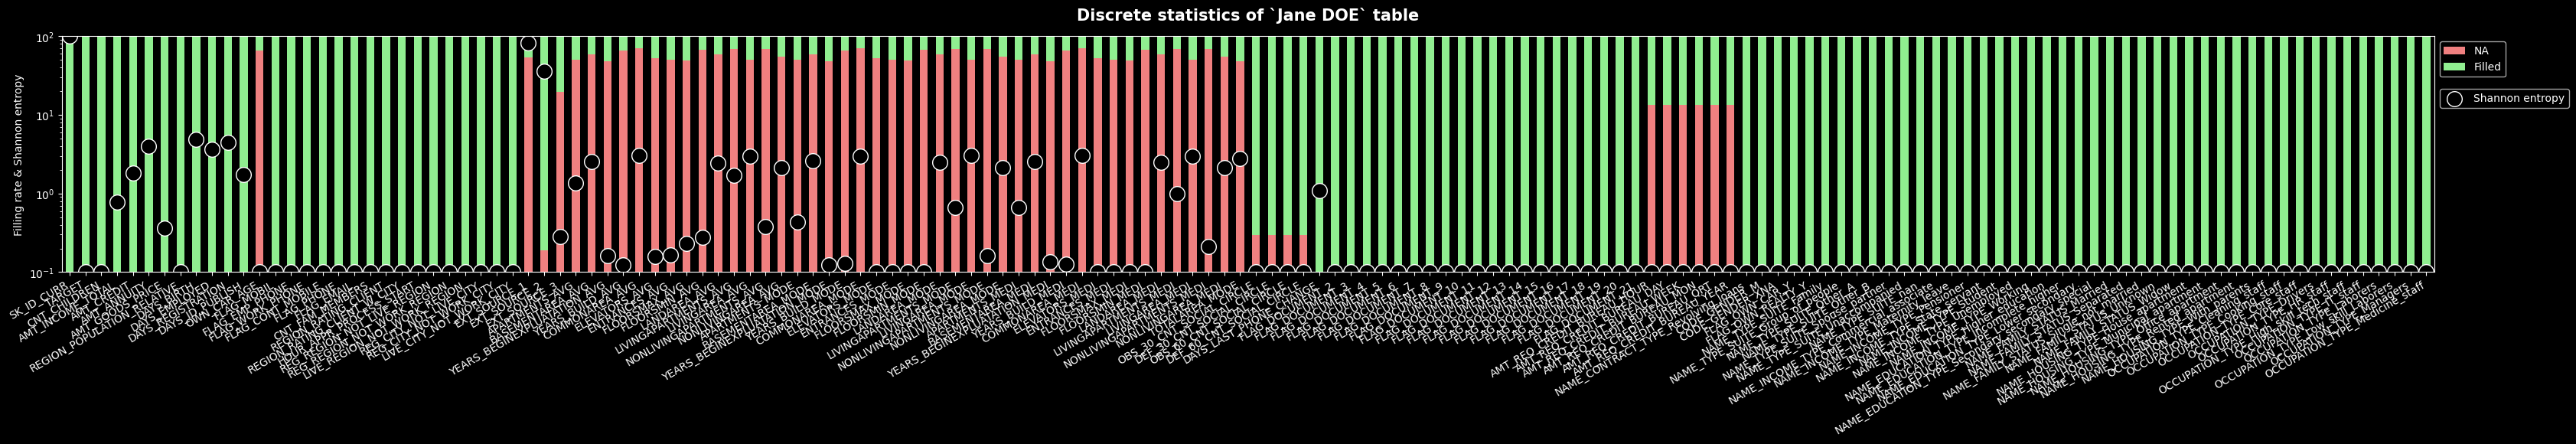

In [ ]:
from pepper.utils import show_discrete_stats
data.info()
display(data.describe())
show_discrete_stats(data[data.columns[:150]], ratio=5)

## Imputation des valeurs manquantes

Hormis quelques exception, les modèles n'aiment pas les valeurs manquantes.

Pour pouvoir passer de la phase d'ingénierie des données à celle de modélisation, il faut s'être d'bord assurés de n'avoir plus de NA. Cela devrait avoir été traité dans le cadre de cette ingénierie, mais il peut rester des reliquats, et pour bien gagder l'entrée de cette phase de modélisation, il est utile de commencer par une passe de vérification (`assert`) et l'application d'une stratégie d'imputation par défaut pour les reliquats de valeurs manquantes.

Par exemple, même si LightGBM accepte des NA, un simple sampling `imblearn`, indispensable dans notre situation de déséquilibre de classes, échouera s'il devait rester des NA :

```
ValueError: Input X contains NaN.

SMOTETomek does not accept missing values encoded as NaN natively.

For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively.

Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values.

See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values
```

Scikit-Learn propose un module `impute` qui propose plusieurs stratégies d'imputations.

Voir la section [**Imputation des valeurs manquantes** (6.4)](https://scikit-learn.org/stable/modules/impute.html) du manuel d'utilisation.

In [28]:
from home_credit.load import load_prep_dataset
from home_credit.best_model_search import default_imputation

data = load_prep_dataset("baseline_v1")
data = data.sample(10_000)

print("NA or INF before imput:", (data.isna() | np.isinf(data)).any().any())

# Cannot be done inplace
data = default_imputation(data)
data_train = data[data.TARGET > -1]
data_test = data[data.TARGET == -1]

print("NA or INF after imput:", (data.isna() | np.isinf(data)).any().any())

display(data)

NA or INF before imput: True
NA or INF after imput: False


,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,CC_NAME_CONTRACT_STATUS_Sent_proposal_MIN_nan,CC_NAME_CONTRACT_STATUS_Sent_proposal_MAX_False,CC_NAME_CONTRACT_STATUS_Sent_proposal_MAX_True,CC_NAME_CONTRACT_STATUS_Sent_proposal_MAX_nan,CC_NAME_CONTRACT_STATUS_Signed_MIN_False,CC_NAME_CONTRACT_STATUS_Signed_MIN_True,CC_NAME_CONTRACT_STATUS_Signed_MIN_nan,CC_NAME_CONTRACT_STATUS_Signed_MAX_False,CC_NAME_CONTRACT_STATUS_Signed_MAX_True,CC_NAME_CONTRACT_STATUS_Signed_MAX_nan
34625,140123.0,0.0,1.0,171000.0,1506816.0,49927.5,1350000.0,0.009630,-13698.0,-2998.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
131054,252004.0,0.0,0.0,112500.0,808650.0,23773.5,675000.0,0.007120,-22542.0,365243.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
53334,161770.0,0.0,1.0,135000.0,354276.0,22770.0,292500.0,0.006305,-12943.0,-3223.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
251289,390765.0,0.0,0.0,135000.0,640080.0,31261.5,450000.0,0.009657,-20692.0,-1119.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
278743,422924.0,0.0,0.0,135000.0,1211049.0,35541.0,1057500.0,0.006671,-16617.0,-2373.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100930,217190.0,0.0,0.0,112500.0,241618.5,23665.5,229500.0,0.010006,-20932.0,-1341.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
236858,374350.0,0.0,2.0,171000.0,533304.0,25785.0,405000.0,0.006207,-11610.0,-1982.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
56810,165835.0,0.0,2.0,184500.0,1206000.0,46066.5,1206000.0,0.010006,-14927.0,-139.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
178527,306875.0,0.0,0.0,405000.0,545040.0,26509.5,450000.0,0.005313,-10514.0,-2025.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


## Réduction de dimentionnalité

Le jeu de données préparée `baseline_v1` contient 790 caractéristiques.

<mark>...freestyle</mark>

Une réduction de dimensionnalité (et par induction, de sparsité) peut améliorer les performances techniques du modèle (espace mémoire, temps d'exécution) mais également la performance métier en réduisant le risque de sur-apprentissage (mémorisation des données plutôt que généralisation).

Voir cet article de Wikipedia à propos du fléau ou malédiction de la dimension [**Curse of dimensionality**](https://en.wikipedia.org/wiki/Curse_of_dimensionality)

Avec un jeu de données d'environ 800 colonnes par 300 000 lignes, il est clair que la réduction de dimensionnalité peut aider à accélérer l'entraînement du modèle et à améliorer les performances.

Une approche de réduction de dimensionnalité linéaire, comme l'analyse en composantes principales (PCA), peut être un bon point de départ. PCA permet de transformer les données en un espace de dimensions réduites, en maximisant la variance des données projetées sur ces dimensions réduites. Cette approche est simple à mettre en œuvre et est bien adaptée aux jeux de données de grande dimension.

Cependant, il peut y avoir des cas où la structure sous-jacente des données n'est pas linéaire, et cela semble être le cas notamment pour les 3 sources externes de scoring client qui caracolent en têtre des caractéristiques importantes (les facteurs les plus déterminants de la prédiction). Il est donc très probable qu'une approche non linéaire telle que t-SNE (t-Distributed Stochastic Neighbor Embedding) sera plus appropriée. t-SNE est capable de préserver les relations non linéaires entre les données, mais il peut être plus coûteux en temps de calcul que PCA.

Notons que la réduction de dimensionnalité peut entraîner une perte d'information, il conviendra donc d'avaluer son impact sur les performances dans le cadre du benchmark.

**TODO**

## Echantillonnage avec rééquilibrage de classes

Les deux classes cibles sont déséquilibrées : les clients défaillants ne représentent que $8\,\%$ des clients.

Ce sont pourtant ces clients qu'il faut spécialement pourvoir identifier en minimisant les faux négatifs plutôt que les faux positifs.

Pour entraîner un modèle à reconnaître ces cas de défaillance, il convient de lui fournir un échantillon ré-équilibré (où la moitié de l'effectif correspond à ces cas de défaillance).

Il existe plusieurs techniques de sous-échantillonnage (par exemple le sous échantillonnage aléatoire ou NearMiss), sur-échantillonnage (par exemple SMOTE et ses variantes) et combinées des deux (par exemple SMOTETomek).

La plupart de ces techniques sont mises en oeuvre par la librairie [**`imblearn`**](https://imbalanced-learn.org/stable/install.html) que nous allons utiliser.

### Exemple de sous-échantillonnage

Exemple d'utilisation de [**`RandomUnderSampler`**](https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html) (extrait de la documentation de l'API).

In [ ]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import RandomUnderSampler
X, y = make_classification(
    n_classes=2, class_sep=2,
    weights=[0.1, 0.9], n_informative=3, n_redundant=1, flip_y=0,
    n_features=20, n_clusters_per_class=1, n_samples=1000, random_state=10
)
print('Original dataset shape %s' % Counter(y))

rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_res))

Original dataset shape Counter({1: 900, 0: 100})
Resampled dataset shape Counter({0: 100, 1: 100})


### Exemple de sur-échantillonnage

Exemple d'utilisation de [**`SMOTE`**](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html) (extrait de la documentation de l'API).

In [ ]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
X, y = make_classification(n_classes=2, class_sep=2,
weights=[0.1, 0.9], n_informative=3, n_redundant=1, flip_y=0,
n_features=20, n_clusters_per_class=1, n_samples=1000, random_state=10)
print('Original dataset shape %s' % Counter(y))

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_res))

Original dataset shape Counter({1: 900, 0: 100})
Resampled dataset shape Counter({0: 900, 1: 900})


### Exemple hybride

Exemple d'utilisation de [**`SMOTETomek`**](https://imbalanced-learn.org/stable/references/generated/imblearn.combine.SMOTETomek.html) (extrait de la documentation de l'API).

In [ ]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.combine import SMOTETomek
X, y = make_classification(n_classes=2, class_sep=2,
weights=[0.1, 0.9], n_informative=3, n_redundant=1, flip_y=0,
n_features=20, n_clusters_per_class=1, n_samples=1000, random_state=10)
print('Original dataset shape %s' % Counter(y))

smt = SMOTETomek(random_state=42)
X_res, y_res = smt.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_res))

Original dataset shape Counter({1: 900, 0: 100})
Resampled dataset shape Counter({0: 900, 1: 900})


## Partition du jeu de données

Pas grand chose à dire à ce sujet, c'est standard : séparation fixée entre le jeu d'entraînement et le jeu de test à soumettre aux évaluateurs de la compétition.

Et plus spécifiquement, équilibrage de l'échantillonage, kfold stratifié.

## Choix du normalisateur des données

Cela se joue a priori entre le `StandardScaler` et le `MinMaxScaler`.

Mais ce ne sont pas les deux seules options à envisager.

Le choix entre StandardScaler et MinMaxScaler dépend de la distribution des données et des algorithmes utilisés.

Si les données suivent approximativement une distribution normale et que les valeurs des caractéristiques ont des écarts types différents, alors le `StandardScaler` est une bonne option car il va centrer les données autour de zéro et les mettre à l'échelle en divisant par l'écart-type. Cela permettra à nos algorithmes de prendre en compte les écarts types des caractéristiques et de les mettre à la même échelle. Les algorithmes qui fonctionnent bien avec des données centrées autour de zéro sont, par exemple, la régression logistique et les réseaux de neurones.

Si les données ne suivent pas approximativement une distribution normale, ou que les données incluent des valeurs aberrantes (outliers), alors le `MinMaxScaler` est une meilleure option car il va mettre toutes les caractéristiques sur la même échelle en les ramenant entre 0 et 1. Les algorithmes qui fonctionnent bien avec des données mises à l'échelle de cette manière sont, par exemple, les arbres de décision et les forêts aléatoires.

Dans notre cas, étant donné que nous avons de nombreuses caractéristiques binaires issues du hot encoding, le `MinMaxScaler` peut être une meilleure option car il va ramener toutes les caractéristiques sur la même échelle et faciliter l'interprétation de l'importance des caractéristiques dans nos modèles. Cependant, il peut être intéressant de tester les deux options pour voir laquelle fonctionne le mieux suivant nos données et nos algorithmes.

Les autres options à envisager:
* `RobustScaler`: Il est similaire à StandardScaler mais utilise la médiane et le quantile au lieu de la moyenne et de l'écart type. Il est plus robuste aux valeurs aberrantes que `StandardScaler`.
* `MaxAbsScaler`: Il divise chaque valeur par la valeur absolue maximale de chaque colonne. Il est utile pour les données très dispersées avec des valeurs beaucoup plus grandes que les autres.
* `PowerTransformer`: Il peut effectuer une transformation de puissance sur les données pour les rendre plus gaussiennes. Il est utile pour les modèles qui supposent une distribution gaussienne des données telles que la régression linéaire et la régression logistique.
* `QuantileTransformer`: Il transforme les données en fonction de la densité de probabilité estimée de chaque fonction de distribution marginale. Il est utile pour les modèles qui supposent une distribution uniforme des données.

Chaque *scaler* sera plus ou moins adapté suivant le couple d'un jeu de caractéristiques et d'un modèle.

Il s'agit donc de faire d'une part des choix éclairés par les connaissances que l'on a des données et des modèles, mais surtout, de s'inscrire pleinement dans une démarche empirique (recherche en grille sur la base d'un pipeline paramétrique (qui permet de faire varier les combinaisons données-scaler-modèle)).

# Evaluation des modèles

Nous généralisons la fonction `kfold_lightgbm` qui nous a largement inspirés, ce qu'il faut bien lui reconnaître.

En effet, comment motiver les passionnés qui partagent leurs connaissances et savoir-faires avec la communauté sans contrepartie financière directe, à persister dans cette démarche, si on ne leur reconnaît pas au moins la paternité de leurs créations ? Nous vivons une époque cynique et outrancière, n'en soyons pas complices.

L'auteur de ce noyau de référence qui a inspiré nombre de compétiteurs est https://www.kaggle.com/code/jsaguiar

Dans cette généralisation, nous apportons les éléments suivants :
* passage du classifieur en paramètre (généralisation), pour être en mesure de réaliser notre benchmark compétitif,
* échantillonnage qui rééquilibre les deux classes, avec un paramètre pour passer un sampler `imblearn` paramétré avec une stratégie,
* normalisation des données à l'aide d'un *scaler* également passé en paramètre
* passage d'une fonction de perte *métier* spécifique en remplacement de l'AUC ROC par défaut
* ajout de mesures supplémentaires pour mettre en évidence les performances : on commence avec un F beta score avec un beta >= 1 pour favoriser la précision sur le rappel (les faux positifs sont préférables sur les faux négatifs, il s'agit donc de favoriser le score de précision sur le score de rappel par rapport au score F1 (F beta avec beta=1))
* retour d'un dictionnaire comprenant :
    * la prédiction sur le jeu de test
    * l'importance des catactéristiques
    * chacun des scores, par fold et global, pour chacune des mesures : AUC ROC, Fbeta, etc
* Externalisation pour un traitement spécifiques et optionnel:
    * de l'enregistrement et de la soumission des prédictions sur le jeu de test,
    * des affichages : les rapport graphiques
    * qui seront produits par des fonctions ad hoc sur la base des résultats produits par cette fonction.

Cela donne cette fonction `kfold_eval_model` du module `home_credit.best_model_search`.

Testons cette fonction à périmètre fonctionnel constant, de sorte à obtenir les mêmes résultats qu'avec `kfold_lightgbm` sur un échantillon de $10\,000$ individus.

In [6]:
from home_credit.load import load_prep_dataset
data = load_prep_dataset("baseline_v1")
data = data.sample(10_000)
display(data.head(1))

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,CC_NAME_CONTRACT_STATUS_Sent_proposal_MIN_nan,CC_NAME_CONTRACT_STATUS_Sent_proposal_MAX_False,CC_NAME_CONTRACT_STATUS_Sent_proposal_MAX_True,CC_NAME_CONTRACT_STATUS_Sent_proposal_MAX_nan,CC_NAME_CONTRACT_STATUS_Signed_MIN_False,CC_NAME_CONTRACT_STATUS_Signed_MIN_True,CC_NAME_CONTRACT_STATUS_Signed_MIN_nan,CC_NAME_CONTRACT_STATUS_Signed_MAX_False,CC_NAME_CONTRACT_STATUS_Signed_MAX_True,CC_NAME_CONTRACT_STATUS_Signed_MAX_nan
225876,361628,0,0,90000.0,308133.0,14953.5,234000.0,0.016612,-15873,-8564,...,True,False,False,True,False,False,True,False,False,True


## Isofonctionnalité avec `lightgbm_kernel.kfold_lightgbm`

<mark>**TODO** Améliorer les traces (post soutenance)</mark>

In [7]:
from home_credit.best_model_search import kfold_train_and_eval_model
from home_credit.lightgbm_kernel_v2 import get_opt_lgbm_classifier
clf = get_opt_lgbm_classifier()
res = kfold_train_and_eval_model(
    data, clf, imb_sampler=None, scaler=None,
    verbosity=3
)


Starting train and eval of:
Labeled dataset of shape: (10000, 790)
Features set of shape: (10000, 788)

With:
Classifier: 


LGBMClassifier(callbacks=None, colsample_bytree=0.9497036, learning_rate=0.02,
               max_depth=8, min_child_weight=39.3259775,
               min_split_gain=0.0222415, n_estimators=10000, n_jobs=4,
               num_leaves=34, reg_alpha=0.041545473, reg_lambda=0.0735294,
               subsample=0.8715623)

Loss function: 


{'AUC': <function sklearn.metrics._ranking.roc_auc_score(y_true, y_score, *, average='macro', sample_weight=None, max_fpr=None, multi_class='raise', labels=None)>}

Eval metrics: 


{'F2': <function home_credit.best_model_search.<lambda>(y_valid, y_pred)>,
 'AUC': <function sklearn.metrics._ranking.roc_auc_score(y_true, y_score, *, average='macro', sample_weight=None, max_fpr=None, multi_class='raise', labels=None)>}

On 5 KFolds: 



'You should consider to pass a `imblearn` resampler through the `imb_sampler` parameter.'


Train vs. test subsets shapes
	Train shape: (8605, 788)
	Test shape: (1395, 788)

Evaluate the 1-th fold (on 5)
[200]	training's binary_logloss: 0.209714	valid_1's binary_logloss: 0.247878
Fold  0 F2: 0.000000
Fold  0 AUC: 0.730760

Evaluate the 2-th fold (on 5)
[200]	training's binary_logloss: 0.213283	valid_1's binary_logloss: 0.234768
[400]	training's binary_logloss: 0.186137	valid_1's binary_logloss: 0.2357
Fold  1 F2: 0.019231
Fold  1 AUC: 0.759607

Evaluate the 3-th fold (on 5)
[200]	training's binary_logloss: 0.20929	valid_1's binary_logloss: 0.253238
Fold  2 F2: 0.008787
Fold  2 AUC: 0.750649

Evaluate the 4-th fold (on 5)
[200]	training's binary_logloss: 0.209543	valid_1's binary_logloss: 0.25362
[400]	training's binary_logloss: 0.18269	valid_1's binary_logloss: 0.256464
Fold  3 F2: 0.000000
Fold  3 AUC: 0.746350

Evaluate the 5-th fold (on 5)
[200]	training's binary_logloss: 0.210569	valid_1's binary_logloss: 0.244876
[400]	training's binary_logloss: 0.18439	valid_1's binary

### Extraction des résultats

In [8]:
resamples = res["resamples"]
preds = res["preds"]
scores = res["scores"]
feat_imps = res["feat_imps"]

X_train = resamples["X_train"]
X_test = resamples["X_test"]
y_train = resamples["y_train"]

train_preds = preds["train"]
test_preds = preds["test"]

train_pred_proba = train_preds["proba"]
train_pred_discr = train_preds["discr"]

test_pred_proba = test_preds["proba"]
test_pred_discr = test_preds["discr"]

La classe minoritaire est prédite dans moins de $0.5\,\%$ des cas sur le jeu d'entraînement et jamais sur le jeu de test : c'est une conséquence directe du déséquilibre de classes!

In [9]:
import numpy as np
display(train_pred_proba)
display(np.unique(train_pred_discr, return_counts=True))
display(test_pred_proba)
display(np.unique(test_pred_discr, return_counts=True))

array([0.01886309, 0.03073775, 0.01901879, ..., 0.01865922, 0.02502743,
       0.07552042])

(array([0., 1.]), array([8600,    5], dtype=int64))

array([0.03385028, 0.22384651, 0.04483355, ..., 0.07596373, 0.0500324 ,
       0.18335337])

(array([0.]), array([1395], dtype=int64))

### Visualisation de l'importance des caractéristiques

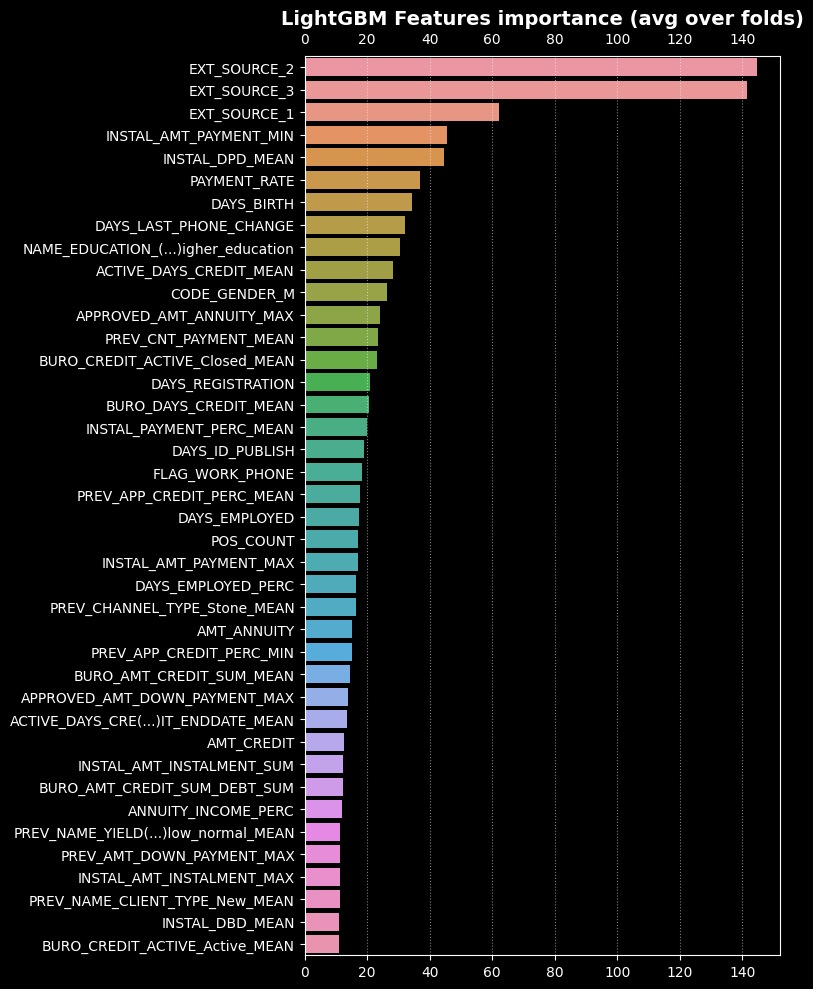

In [10]:
from home_credit.lightgbm_kernel_v2 import display_importances
selected_best_feats = display_importances(feat_imps)

### Affichage des scores par pli et globaux

In [11]:
display(scores)

{'F2': {'over_folds': [0.0,
   0.019230769230769232,
   0.008787346221441126,
   0.0,
   0.0],
  'overall': 0.005472455308281649},
 'AUC': {'over_folds': [0.7307598897762831,
   0.7596071442483737,
   0.7506489220312376,
   0.7463495075449534,
   0.765373946002362],
  'overall': 0.7505985643315459}}

### Affichage de la courbe ROC

overall AUC verif: 0.7505985643315459


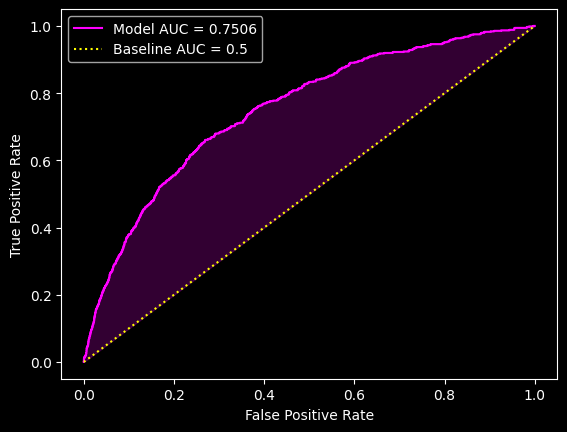

In [12]:
from home_credit.best_model_search import plot_roc_curve
from sklearn.metrics import roc_auc_score
y_train = res["resamples"]["y_train"]
train_pred_proba = res["preds"]["train"]["proba"]
overall_auc = res["scores"]['AUC']['overall']
print("overall AUC verif:", roc_auc_score(y_train, train_pred_proba))
plot_roc_curve(y_train, train_pred_proba, overall_auc)

## Effet du ré-échantillonage

<mark>**TODO** Faire taire les traces de LGBM si verbosity=0 (après soutenance)</mark>

In [13]:
from home_credit.load import load_prep_dataset
from home_credit.best_model_search import kfold_train_and_eval_model
from home_credit.lightgbm_kernel_v2 import get_opt_lgbm_classifier

data = load_prep_dataset("baseline_v1")
data = data.sample(10_000)
clf = get_opt_lgbm_classifier()
res = kfold_train_and_eval_model(
    data, clf, scaler=None,
    verbosity=3
)


Starting train and eval of:
Labeled dataset of shape: (10000, 790)
Features set of shape: (10000, 788)

With:
Classifier: 


LGBMClassifier(callbacks=None, colsample_bytree=0.9497036, learning_rate=0.02,
               max_depth=8, min_child_weight=39.3259775,
               min_split_gain=0.0222415, n_estimators=10000, n_jobs=4,
               num_leaves=34, reg_alpha=0.041545473, reg_lambda=0.0735294,
               subsample=0.8715623)

Loss function: 


{'AUC': <function sklearn.metrics._ranking.roc_auc_score(y_true, y_score, *, average='macro', sample_weight=None, max_fpr=None, multi_class='raise', labels=None)>}

Eval metrics: 


{'F2': <function home_credit.best_model_search.<lambda>(y_valid, y_pred)>,
 'AUC': <function sklearn.metrics._ranking.roc_auc_score(y_true, y_score, *, average='macro', sample_weight=None, max_fpr=None, multi_class='raise', labels=None)>}

On 5 KFolds: 

Resampling
Sampler: 


SMOTETomek()

Original dataset shape: Counter({0.0: 7898, -1.0: 1379, 1.0: 723})
Resampled dataset shape: Counter({1.0: 7675, -1.0: 7665, 0.0: 7568})

Train vs. test subsets shapes
	Train shape: (15243, 788)
	Test shape: (7665, 788)

Evaluate the 1-th fold (on 5)
[200]	training's binary_logloss: 0.144589	valid_1's binary_logloss: 0.18575
[400]	training's binary_logloss: 0.104959	valid_1's binary_logloss: 0.164252
[600]	training's binary_logloss: 0.0884584	valid_1's binary_logloss: 0.161597
[800]	training's binary_logloss: 0.0772599	valid_1's binary_logloss: 0.16088
[1000]	training's binary_logloss: 0.0688881	valid_1's binary_logloss: 0.160776
Fold  0 F2: 0.915981
Fold  0 AUC: 0.974638

Evaluate the 2-th fold (on 5)
[200]	training's binary_logloss: 0.148935	valid_1's binary_logloss: 0.169165
[400]	training's binary_logloss: 0.109097	valid_1's binary_logloss: 0.143482
[600]	training's binary_logloss: 0.0922306	valid_1's binary_logloss: 0.137708
[800]	training's binary_logloss: 0.0808292	valid_1's bina

Avec un AUC de 0.98, il y a probablement du sur-apprentissage, ce qui n'est surprenant avec une échentillon aussi réduit.

Cela dit, l'impact du rééquilibrage des classes est manifeste.

overall AUC verif: 0.981197102836562


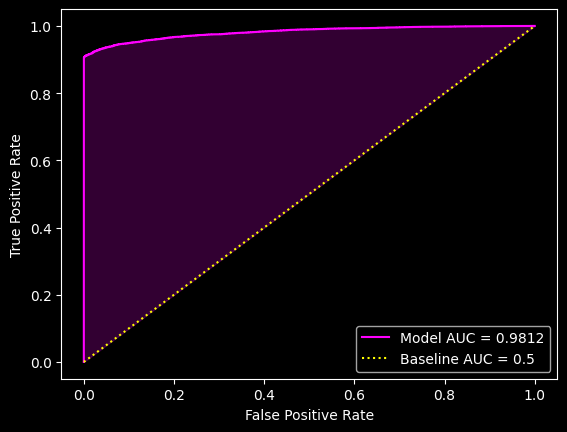

In [14]:
from home_credit.best_model_search import plot_roc_curve
from sklearn.metrics import roc_auc_score
y_train = res["resamples"]["y_train"]
train_pred_proba = res["preds"]["train"]["proba"]
overall_auc = res["scores"]['AUC']['overall']
print("overall AUC verif:", roc_auc_score(y_train, train_pred_proba))
plot_roc_curve(y_train, train_pred_proba, overall_auc)

Matrice de confusion


Confusion matrix


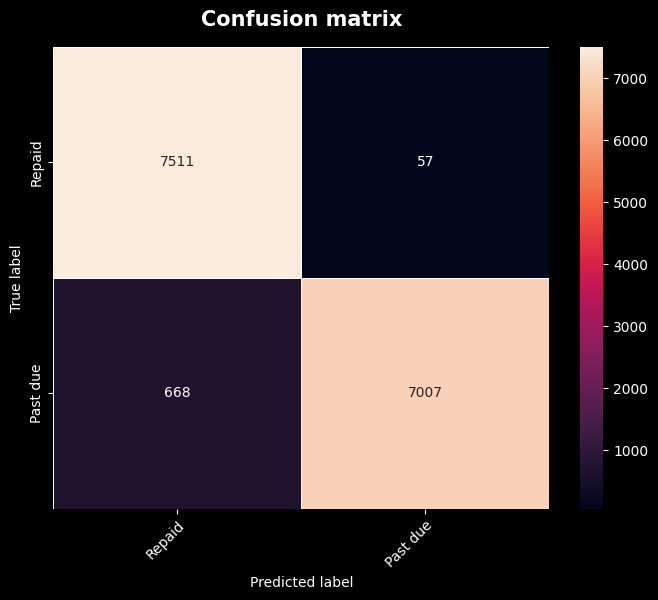

In [15]:
from pepper.scoring import show_confusion_matrix
y_train = res["resamples"]["y_train"]
train_pred_discr = res["preds"]["train"]["discr"]
show_confusion_matrix(y_train, train_pred_discr, ["Repaid", "Past due"])

Importance des caractéristiques

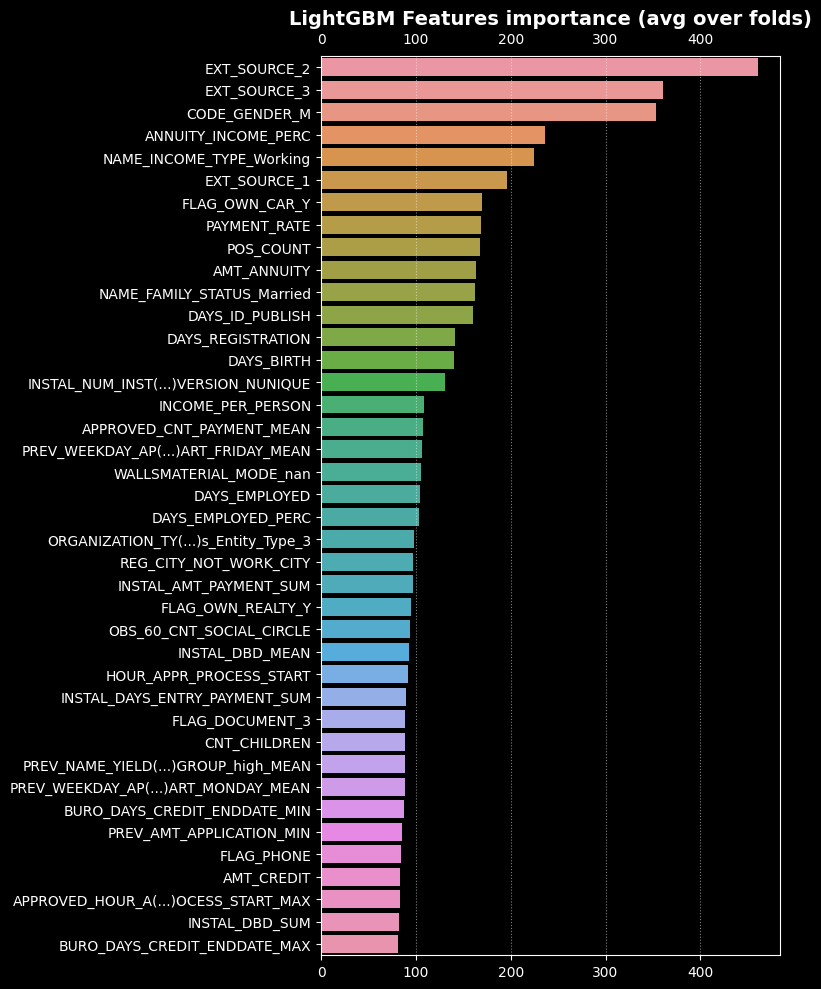

In [16]:
from home_credit.lightgbm_kernel_v2 import display_importances
feat_imps = res["feat_imps"]
selected_best_feats = display_importances(feat_imps)

## Effet de la mise à l'échelle

In [17]:
from home_credit.load import load_prep_dataset
from home_credit.best_model_search import kfold_train_and_eval_model
from home_credit.lightgbm_kernel_v2 import get_opt_lgbm_classifier

data = load_prep_dataset("baseline_v1")
data = data.sample(10_000)
clf = get_opt_lgbm_classifier()
res = kfold_train_and_eval_model(
    data, clf,
    verbosity=3
)


Starting train and eval of:
Labeled dataset of shape: (10000, 790)
Features set of shape: (10000, 788)

With:
Classifier: 


LGBMClassifier(callbacks=None, colsample_bytree=0.9497036, learning_rate=0.02,
               max_depth=8, min_child_weight=39.3259775,
               min_split_gain=0.0222415, n_estimators=10000, n_jobs=4,
               num_leaves=34, reg_alpha=0.041545473, reg_lambda=0.0735294,
               subsample=0.8715623)

Loss function: 


{'AUC': <function sklearn.metrics._ranking.roc_auc_score(y_true, y_score, *, average='macro', sample_weight=None, max_fpr=None, multi_class='raise', labels=None)>}

Eval metrics: 


{'F2': <function home_credit.best_model_search.<lambda>(y_valid, y_pred)>,
 'AUC': <function sklearn.metrics._ranking.roc_auc_score(y_true, y_score, *, average='macro', sample_weight=None, max_fpr=None, multi_class='raise', labels=None)>}

On 5 KFolds: 

Resampling
Sampler: 


SMOTETomek()

Original dataset shape: Counter({0.0: 7975, -1.0: 1351, 1.0: 674})
Resampled dataset shape: Counter({1.0: 7763, -1.0: 7715, 0.0: 7649})

Train vs. test subsets shapes
	Train shape: (15412, 788)
	Test shape: (7715, 788)

Evaluate the 1-th fold (on 5)
[200]	training's binary_logloss: 0.136921	valid_1's binary_logloss: 0.167385
[400]	training's binary_logloss: 0.0999356	valid_1's binary_logloss: 0.145967
[600]	training's binary_logloss: 0.0838234	valid_1's binary_logloss: 0.142088
[800]	training's binary_logloss: 0.0730306	valid_1's binary_logloss: 0.1403
[1000]	training's binary_logloss: 0.0650174	valid_1's binary_logloss: 0.139803
[1200]	training's binary_logloss: 0.0588551	valid_1's binary_logloss: 0.13964
Fold  0 F2: 0.926587
Fold  0 AUC: 0.980849

Evaluate the 2-th fold (on 5)
[200]	training's binary_logloss: 0.138072	valid_1's binary_logloss: 0.160322
[400]	training's binary_logloss: 0.10187	valid_1's binary_logloss: 0.136074
[600]	training's binary_logloss: 0.0859553	valid_1's bina

overall AUC verif: 0.9822982186560667


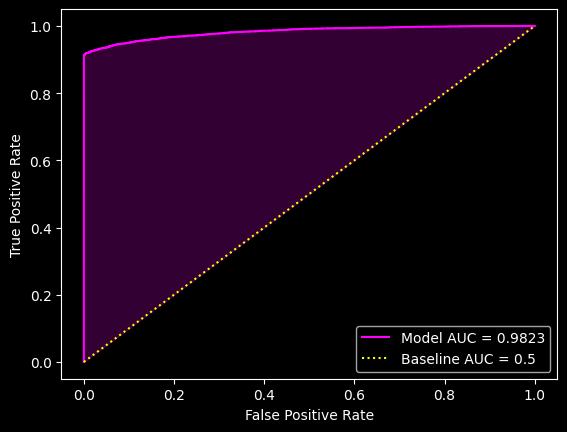

In [3]:
from home_credit.best_model_search import plot_roc_curve
from sklearn.metrics import roc_auc_score
y_train = res["resamples"]["y_train"]
train_pred_proba = res["preds"]["train"]["proba"]
overall_auc = res["scores"]['AUC']['overall']
print("overall AUC verif:", roc_auc_score(y_train, train_pred_proba))
plot_roc_curve(y_train, train_pred_proba, overall_auc)

Matrice de confusion


Confusion matrix


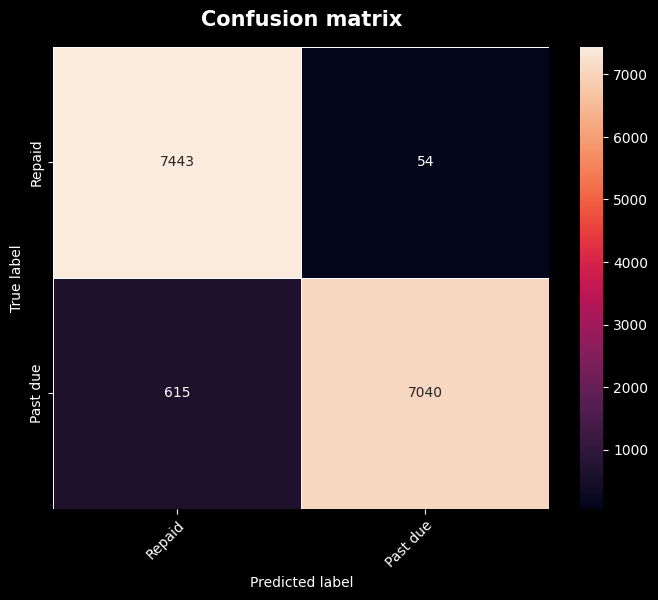

In [6]:
from pepper.scoring import show_confusion_matrix
y_train = res["resamples"]["y_train"]
train_pred_discr = res["preds"]["train"]["discr"]
show_confusion_matrix(y_train, train_pred_discr, ["Repaid", "Past due"])

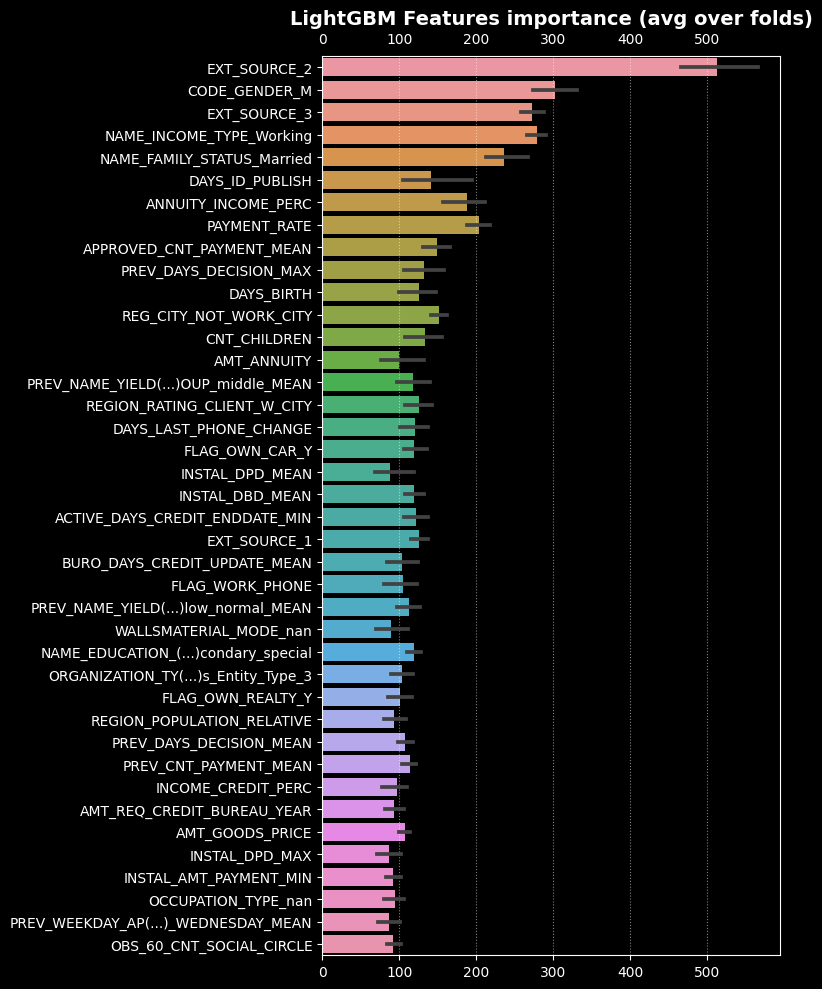

In [9]:
from home_credit.lightgbm_kernel_v2 import display_importances
feat_imps = res["feat_imps"]
selected_best_feats = display_importances(feat_imps)

# Benchmark des modèles

## Modéle de référence : classifieur naïf

Nous utilisons un [**`DummyClassifier`**](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html) de Scikit-learn paramétré avec `strategy="most_frequent"`.

Paramétré avec cette stratégie, le classifieur naïf prédira systématiquement la classe dominante.

Ce classifieur va nous servir de base de référence à laquelle comparer les performances prédictives de classifieurs plus avancés.

Le classifieur naïf donne nécessairement un score AUC ROC de 0,5 [[**StackExchange** > *Can AUC-ROC be between 0-0.5?*](https://stats.stackexchange.com/questions/266387/can-auc-roc-be-between-0-0-5)].

In [ ]:
import numpy as np
from sklearn.dummy import DummyClassifier
X = np.array([-1, 1, 1, 1])
y = np.array([0, 1, 1, 1])
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X, y)
dummy_clf.predict(X)
dummy_clf.score(X, y)

0.75

## Régression Logistique

Références :
* http://faculty.marshall.usc.edu/gareth-james/ => n'est plus accessible
* https://www.oreilly.com/library/view/hands-on-machine-learning/9781491962282/ => pas gratuit

Ici, je me concentrerai sur la mise en œuvre du modèle plutôt que sur l'explication des détails, mais pour ceux qui veulent en savoir plus sur la théorie des algorithmes d'apprentissage automatique, je recommande à la fois "An Introduction to Statistical Learning" et "Hands-On Machine Learning with Scikit-Learn and TensorFlow". Ces deux livres présentent la théorie ainsi que le code nécessaire pour créer les modèles (en R et en Python respectivement). Ils enseignent tous deux avec l'idée que la meilleure façon d'apprendre est de faire, et ils sont très efficaces!

Pour obtenir une base de référence, nous utiliserons toutes les caractéristiques, après encodage des variables catégorielles. Nous prétraiterons les données en remplissant les valeurs manquantes (imputation) et en normalisant la plage des caractéristiques (mise à l'échelle des caractéristiques). Le code suivant effectue ces deux étapes de prétraitement.

----

La régression logistique de scikit-learn n'a pas de méthode intégrée pour récupérer les importances de caractéristiques (*feature importances*) comme c'est le cas pour les modèles de type arbre, tels que les RandomForest ou les XGBoost.

Cependant, il est possible d'approximer les importances de caractéristiques en utilisant les coefficients de régression. Les coefficients indiquent l'importance relative de chaque caractéristique dans la prédiction de la variable cible. Plus un coefficient est grand, plus la caractéristique associée est importante. Evidemment, cela ne tient que sous hypothèse que les données ont été préalablement normalisées et sont donc à la même échelle.

Test sur l'échantillon de $10\,000$ avec ré-échantillonnage et mise à l'échelle par défaut.

In [1]:
from home_credit.load import load_prep_dataset
from home_credit.best_model_search import kfold_train_and_eval_model
from sklearn.linear_model import LogisticRegression

data = load_prep_dataset("baseline_v1")
data = data.sample(10_000)
clf = LogisticRegression(C=1e-4, random_state=42)
res = kfold_train_and_eval_model(
    data, clf,
    verbosity=3
)


Starting train and eval of:
Labeled dataset of shape: (10000, 790)
Features set of shape: (10000, 788)

With:
Classifier: 


LogisticRegression(C=0.0001, random_state=42)

Loss function: 


{'AUC': <function sklearn.metrics._ranking.roc_auc_score(y_true, y_score, *, average='macro', sample_weight=None, max_fpr=None, multi_class='raise', labels=None)>}

Eval metrics: 


{'F2': <function home_credit.best_model_search.<lambda>(y_valid, y_pred)>,
 'AUC': <function sklearn.metrics._ranking.roc_auc_score(y_true, y_score, *, average='macro', sample_weight=None, max_fpr=None, multi_class='raise', labels=None)>}

On 5 KFolds: 

Resampling
Sampler: 


SMOTETomek()

Original dataset shape: Counter({0.0: 7921, -1.0: 1399, 1.0: 680})
Resampled dataset shape: Counter({1.0: 7742, -1.0: 7655, 0.0: 7582})

Train vs. test subsets shapes
	Train shape: (15324, 788)
	Test shape: (7655, 788)

Evaluate the 1-th fold (on 5)
Fold  0 F2: 0.720709
Fold  0 AUC: 0.701474

Evaluate the 2-th fold (on 5)
Fold  1 F2: 0.736849
Fold  1 AUC: 0.698648

Evaluate the 3-th fold (on 5)
Fold  2 F2: 0.731494
Fold  2 AUC: 0.702636

Evaluate the 4-th fold (on 5)
Fold  3 F2: 0.713490
Fold  3 AUC: 0.711704

Evaluate the 5-th fold (on 5)
Fold  4 F2: 0.741157
Fold  4 AUC: 0.732343
Full F2: 0.728718
Full AUC: 0.708485


Courbe ROC et AUC :

overall AUC verif: 0.7084850855821695


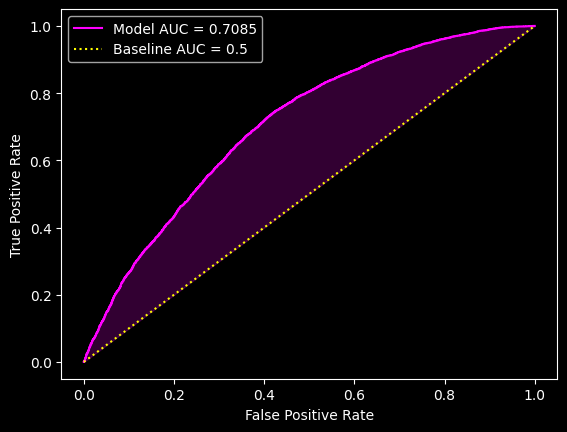

In [2]:
from home_credit.best_model_search import plot_roc_curve
from sklearn.metrics import roc_auc_score
y_train = res["resamples"]["y_train"]
train_pred_proba = res["preds"]["train"]["proba"]
overall_auc = res["scores"]['AUC']['overall']
print("overall AUC verif:", roc_auc_score(y_train, train_pred_proba))
plot_roc_curve(y_train, train_pred_proba, overall_auc)

Matrice de confusion


Confusion matrix


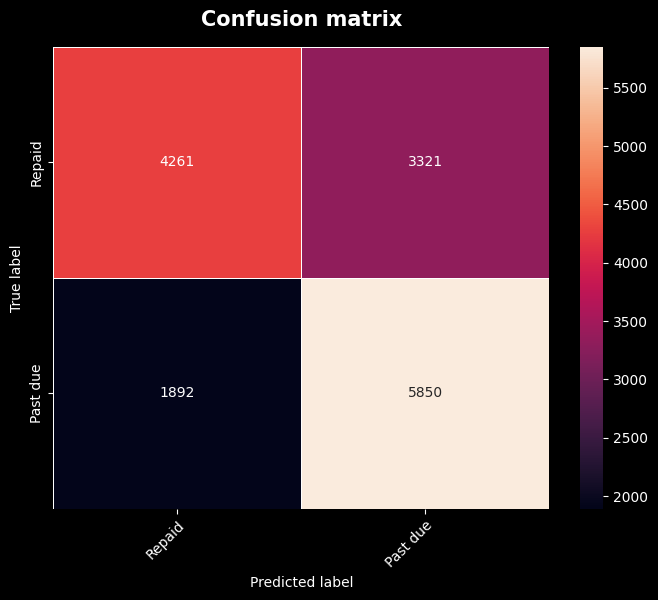

In [3]:
from pepper.scoring import show_confusion_matrix
y_train = res["resamples"]["y_train"]
train_pred_discr = res["preds"]["train"]["discr"]
show_confusion_matrix(y_train, train_pred_discr, ["Repaid", "Past due"])

,feature,importance,fold
0,ACTIVE_AMT_ANNUITY_MAX,-0.000033,0
1,ACTIVE_AMT_ANNUITY_MEAN,-0.000145,0
2,ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN,0.000801,0
3,ACTIVE_AMT_CREDIT_SUM_DEBT_MAX,-0.000114,0
4,ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN,-0.000238,0
...,...,...,...
783,YEARS_BEGINEXPLUATATION_MEDI,-0.000409,4
784,YEARS_BEGINEXPLUATATION_MODE,-0.000290,4
785,YEARS_BUILD_AVG,-0.001552,4
786,YEARS_BUILD_MEDI,-0.001620,4


,importance
feature,
CODE_GENDER_M,0.031026
NAME_EDUCATION_TYPE_Secondary_secondary_special,0.030517
NAME_INCOME_TYPE_Working,0.029999
DAYS_BIRTH,0.018470
BURO_DAYS_CREDIT_MIN,0.018252
...,...
BURO_CREDIT_ACTIVE_Closed_MEAN,-0.016998
NAME_FAMILY_STATUS_Married,-0.019992
EXT_SOURCE_3,-0.029804


,feature,importance
0,CODE_GENDER_M,0.031026
1,NAME_EDUCATION_TYPE_Secondary_secondary_special,0.030517
2,NAME_INCOME_TYPE_Working,0.029999
3,DAYS_BIRTH,0.018470
4,BURO_DAYS_CREDIT_MIN,0.018252
...,...,...
783,BURO_CREDIT_ACTIVE_Closed_MEAN,-0.016998
784,NAME_FAMILY_STATUS_Married,-0.019992
785,EXT_SOURCE_3,-0.029804
786,NAME_EDUCATION_TYPE_Higher_education,-0.032042


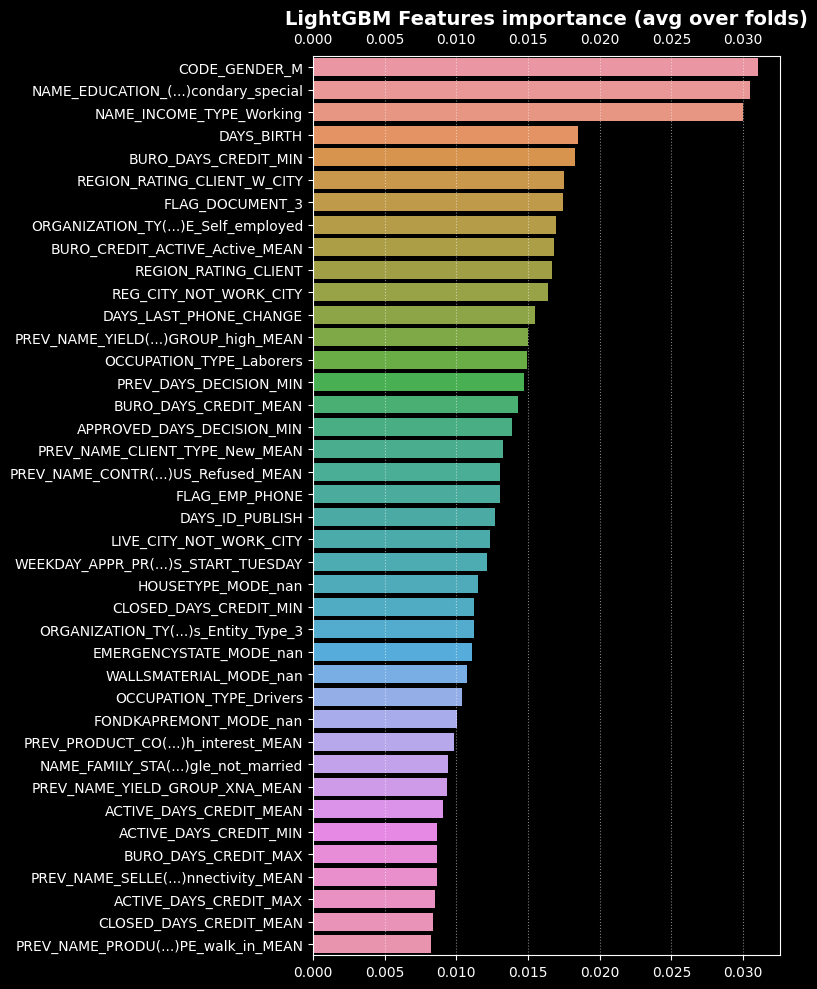

In [4]:
from home_credit.lightgbm_kernel_v2 import display_importances
feat_imps = res["feat_imps"]
selected_best_feats = display_importances(feat_imps)

Références :
* https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
* https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

Nous allons utiliser la [**`LogisticRegression` de Scikit-Learn**](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) pour notre premier modèle. La seule modification que nous apporterons aux paramètres par défaut du modèle sera de baisser le [**paramètre de régularisation, C**](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression), qui contrôle le niveau de sur-apprentissage (une valeur plus faible devrait diminuer le sur-apprentissage). Cela nous donnera des résultats légèrement meilleurs que la `LogisticRegression` par défaut, mais cela fixera tout de même une barre basse pour tous les modèles futurs.

Ici, nous utilisons la syntaxe familière de modélisation de Scikit-Learn : nous créons d'abord le modèle, puis nous l'entraînons en utilisant `.fit` et ensuite nous faisons des prédictions sur les données de test en utilisant `.predict_proba` (rappelez-vous que nous voulons des probabilités et non un 0 ou 1).

Maintenant que le modèle a été entraîné, nous pouvons l'utiliser pour faire des prédictions. Nous voulons prédire les probabilités de non-remboursement d'un prêt, donc nous utilisons la méthode predict.proba du modèle. Cela renvoie un tableau de dimensions m x 2 où m est le nombre d'observations. La première colonne est la probabilité que la cible soit 0 et la deuxième colonne est la probabilité que la cible soit 1 (donc pour une seule ligne, les deux colonnes doivent s'additionner à 1). Nous voulons la probabilité que le prêt ne soit pas remboursé, donc nous sélectionnons la deuxième colonne.

Le code suivant effectue les prédictions et sélectionne la bonne colonne.

In [ ]:
# Save the submission to a csv file
submit.to_csv('log_reg_baseline.csv', index=False)

La soumission a maintenant été sauvegardée dans l'environnement virtuel dans lequel notre notebook s'exécute. Pour accéder à la soumission, à la fin du notebook, nous appuierons sur le bouton bleu "Commit & Run" en haut à droite du noyau. Cela exécute l'ensemble du notebook, puis nous permet de télécharger tous les fichiers qui ont été créés pendant l'exécution.

Une fois que nous avons exécuté le notebook, les fichiers créés sont disponibles dans l'onglet "Versions" sous l'onglet "Output". À partir de là, les fichiers de soumission peuvent être soumis à la compétition ou téléchargés. Comme il y a plusieurs modèles dans ce notebook, il y aura plusieurs fichiers de sortie.

**Le score de base de la régression logistique devrait être d'environ 0,671 lorsqu'il est soumis.**

## Modèle amélioré : Forêt aléatoire

Pour essayer de battre les mauvaises performances de notre modèle de base, nous pouvons mettre à jour l'algorithme. Essayons d'utiliser une forêt aléatoire sur les mêmes données d'entraînement pour voir comment cela affecte les performances. La forêt aléatoire est un modèle beaucoup plus puissant que la régression logistique, surtout lorsque nous utilisons des centaines d'arbres. Nous utiliserons 100 arbres dans la forêt aléatoire.

Ces prévisions seront également disponibles lorsque nous exécuterons l'ensemble du notebook.

**Ce modèle devrait avoir un score d'environ 0,678 lorsqu'il est soumis.**

In [2]:
from home_credit.load import load_prep_dataset
from home_credit.best_model_search import kfold_train_and_eval_model
from sklearn.ensemble import RandomForestClassifier

data = load_prep_dataset("baseline_v1")
data = data.sample(10_000)

# Create the random forest classifier
clf = RandomForestClassifier(
    n_estimators=100, random_state=42,
    verbose=1, n_jobs=-1
)

# Train and cross eval it
res = kfold_train_and_eval_model(
    data, clf,
    verbosity=3
)


Starting train and eval of:
Labeled dataset of shape: (10000, 790)
Features set of shape: (10000, 788)

With:
Classifier: 


RandomForestClassifier(n_jobs=-1, random_state=42, verbose=1)

Loss function: 


{'AUC': <function sklearn.metrics._ranking.roc_auc_score(y_true, y_score, *, average='macro', sample_weight=None, max_fpr=None, multi_class='raise', labels=None)>}

Eval metrics: 


{'F2': <function home_credit.best_model_search.<lambda>(y_valid, y_pred)>,
 'AUC': <function sklearn.metrics._ranking.roc_auc_score(y_true, y_score, *, average='macro', sample_weight=None, max_fpr=None, multi_class='raise', labels=None)>}

On 5 KFolds: 

Resampling
Sampler: 


SMOTETomek()

Original dataset shape: Counter({0.0: 7891, -1.0: 1373, 1.0: 736})
Resampled dataset shape: Counter({1.0: 7713, -1.0: 7632, 0.0: 7566})

Train vs. test subsets shapes
	Train shape: (15279, 788)
	Test shape: (7632, 788)

Evaluate the 1-th fold (on 5)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


Fold  0 F2: 0.940910
Fold  0 AUC: 0.994281

Evaluate the 2-th fold (on 5)


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.9s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


Fold  1 F2: 0.942714
Fold  1 AUC: 0.992358

Evaluate the 3-th fold (on 5)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


Fold  2 F2: 0.934510
Fold  2 AUC: 0.993590

Evaluate the 4-th fold (on 5)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


Fold  3 F2: 0.929779
Fold  3 AUC: 0.991059

Evaluate the 5-th fold (on 5)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.4s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s


Fold  4 F2: 0.934308
Fold  4 AUC: 0.991845
Full F2: 0.936422
Full AUC: 0.992594


[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


Courbe ROC et AUC :

overall AUC verif: 0.9925937030076379


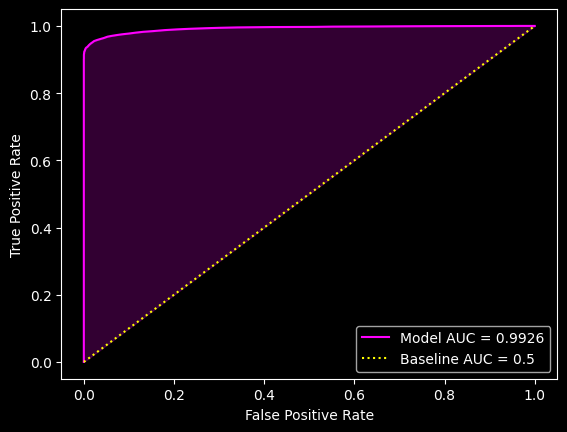

In [3]:
from home_credit.best_model_search import plot_roc_curve
from sklearn.metrics import roc_auc_score
y_train = res["resamples"]["y_train"]
train_pred_proba = res["preds"]["train"]["proba"]
overall_auc = res["scores"]['AUC']['overall']
print("overall AUC verif:", roc_auc_score(y_train, train_pred_proba))
plot_roc_curve(y_train, train_pred_proba, overall_auc)

Matrice de confusion


Confusion matrix


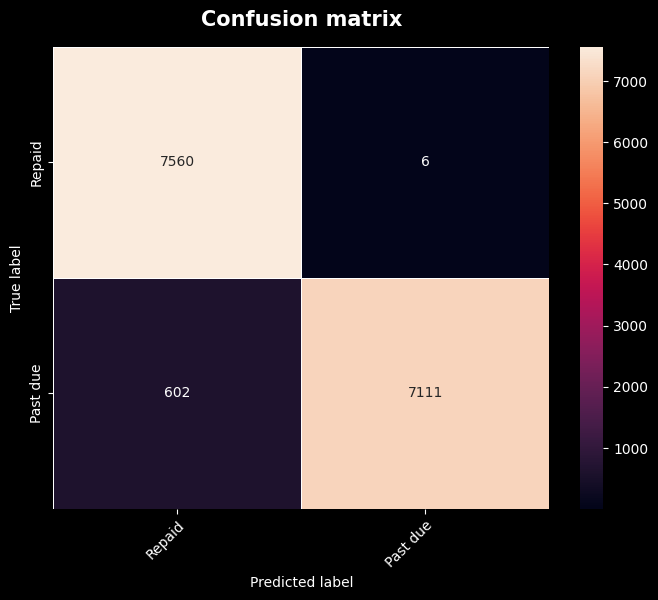

In [4]:
from pepper.scoring import show_confusion_matrix
y_train = res["resamples"]["y_train"]
train_pred_discr = res["preds"]["train"]["discr"]
show_confusion_matrix(y_train, train_pred_discr, ["Repaid", "Past due"])

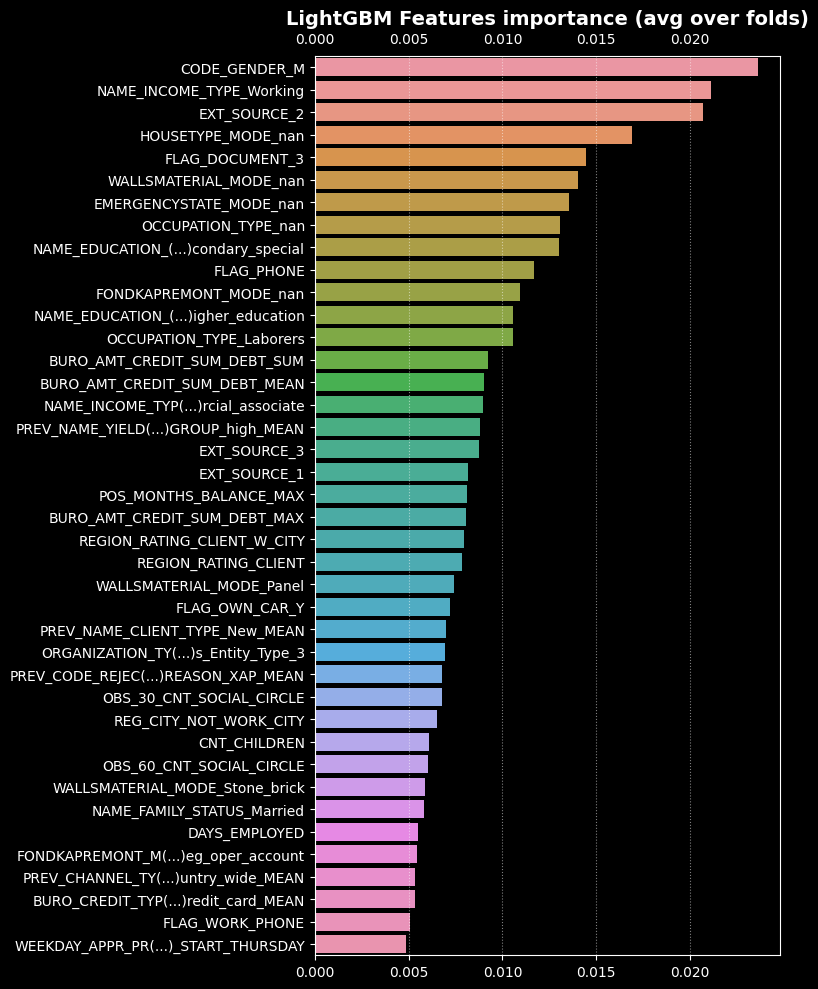

In [5]:
from home_credit.lightgbm_kernel_v2 import display_importances
feat_imps = res["feat_imps"]
selected_best_feats = display_importances(feat_imps)

## Modèle de performance : LGBM

Nous l'avons déjà étudié apprécié plus haut, il a été notre base de départ.

# Importances des caractéristiques et explication de modèle

Valeurs de Shapeley et SHAP

https://shap.readthedocs.io/en/latest/index.html

RuntimeError: Cannot install on Python version 3.11.1; only versions >=3.7,<3.11 are supported.

SHAP fait partie des retardataires.

## Explication de la régression logistique

Exécution de la régression logistique :

On récupère le classifieur entraîné et on interprète à l'aide de SHAP ce qu'il se passe à l'échelle de l'ensemble du jeu de données.

In [6]:
from home_credit.load import load_prep_dataset
from home_credit.best_model_search import kfold_train_and_eval_model
from sklearn.linear_model import LogisticRegression

data = load_prep_dataset("baseline_v1")
sample_10k = data.sample(10_000)
clf = LogisticRegression(C=1e-4, random_state=42)
res = kfold_train_and_eval_model(
    sample_10k, clf,
    verbosity=1,
    return_trained_clf=True
)

Starting train and eval of:
Labeled dataset of shape: (10000, 790)
Features set of shape: (10000, 788)
With:
Classifier: 


LogisticRegression(C=0.0001, random_state=42)

Loss function: 


{'AUC': <function sklearn.metrics._ranking.roc_auc_score(y_true, y_score, *, average='macro', sample_weight=None, max_fpr=None, multi_class='raise', labels=None)>}

Eval metrics: 


{'F2': <function home_credit.best_model_search.<lambda>(y_valid, y_pred)>,
 'AUC': <function sklearn.metrics._ranking.roc_auc_score(y_true, y_score, *, average='macro', sample_weight=None, max_fpr=None, multi_class='raise', labels=None)>}

On 5 KFolds: 
Sampler: 


SMOTETomek()

Original dataset shape: Counter({0.0: 7880, -1.0: 1439, 1.0: 681})
Resampled dataset shape: Counter({1.0: 7732, -1.0: 7623, 0.0: 7563})
	Train shape: (15295, 788)
	Test shape: (7623, 788)
Fold  0 F2: 0.768374
Fold  0 AUC: 0.709677
Fold  1 F2: 0.688719
Fold  1 AUC: 0.674584
Fold  2 F2: 0.711875
Fold  2 AUC: 0.691724
Fold  3 F2: 0.721076
Fold  3 AUC: 0.699175
Fold  4 F2: 0.704945
Fold  4 AUC: 0.688924
Full F2: 0.719011
Full AUC: 0.691448


Interprétation basée sur les valeurs de Shapley (avec SHAP) :

In [8]:
display(res["trained_clf"])

LogisticRegression(C=0.0001, random_state=42)

In [11]:
def logreg_predict_proba(clf, x):
    return clf.predict_proba(x)[:,1]

def logreg_log_odds(clf, x):
    p = clf.predict_log_proba(x)
    return p[:,1] - p[:,0]

In [14]:
display(data)

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,CC_NAME_CONTRACT_STATUS_Sent_proposal_MIN_nan,CC_NAME_CONTRACT_STATUS_Sent_proposal_MAX_False,CC_NAME_CONTRACT_STATUS_Sent_proposal_MAX_True,CC_NAME_CONTRACT_STATUS_Sent_proposal_MAX_nan,CC_NAME_CONTRACT_STATUS_Signed_MIN_False,CC_NAME_CONTRACT_STATUS_Signed_MIN_True,CC_NAME_CONTRACT_STATUS_Signed_MIN_nan,CC_NAME_CONTRACT_STATUS_Signed_MAX_False,CC_NAME_CONTRACT_STATUS_Signed_MAX_True,CC_NAME_CONTRACT_STATUS_Signed_MAX_nan
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,...,True,False,False,True,False,False,True,False,False,True
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,...,True,False,False,True,False,False,True,False,False,True
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,...,True,False,False,True,False,False,True,False,False,True
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,...,False,True,False,False,True,False,False,True,False,False
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,...,True,False,False,True,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356250,456221,-1,0,121500.0,412560.0,17473.5,270000.0,0.002042,-19970,-5169,...,True,False,False,True,False,False,True,False,False,True
356251,456222,-1,2,157500.0,622413.0,31909.5,495000.0,0.035792,-11186,-1149,...,True,False,False,True,False,False,True,False,False,True
356252,456223,-1,1,202500.0,315000.0,33205.5,315000.0,0.026392,-15922,-3037,...,True,False,False,True,False,False,True,False,False,True
356253,456224,-1,0,225000.0,450000.0,25128.0,450000.0,0.018850,-13968,-2731,...,True,False,False,True,False,False,True,False,False,True


In [13]:
import shap

# Exclude non-feature columns
not_feat_names = ["TARGET", "SK_ID_CURR", "SK_ID_BUREAU", "SK_ID_PREV", "index"]
feat_names = data.columns.difference(not_feat_names)
X = data[feat_names]
y = data.TARGET

# make a standard partial dependence plot
sample_ind = 18
fig,ax = shap.partial_dependence_plot(
    "CODE_GENDER_M", logreg_predict_proba, X, model_expected_value=True,
    feature_expected_value=True, show=False, ice=False
)

TypeError: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

In [15]:
explainer = shap.TreeExplainer(clf)
display(explainer)

InvalidModelError: Model type not yet supported by TreeExplainer: <class 'sklearn.linear_model._logistic.LogisticRegression'>

## Explication du modèle LGBM

In [20]:
from home_credit.load import load_prep_dataset
from home_credit.best_model_search import kfold_train_and_eval_model
from home_credit.lightgbm_kernel_v2 import get_opt_lgbm_classifier

data = load_prep_dataset("baseline_v1")
sample_10k = data.sample(10_000)
clf = get_opt_lgbm_classifier()
res = kfold_train_and_eval_model(
    sample_10k, clf,
    verbosity=1,
    return_trained_clf=True
)

Starting train and eval of:
Labeled dataset of shape: (10000, 790)
Features set of shape: (10000, 788)
With:
Classifier: 


LGBMClassifier(callbacks=None, colsample_bytree=0.9497036, learning_rate=0.02,
               max_depth=8, min_child_weight=39.3259775,
               min_split_gain=0.0222415, n_estimators=10000, n_jobs=4,
               num_leaves=34, reg_alpha=0.041545473, reg_lambda=0.0735294,
               subsample=0.8715623)

Loss function: 


{'AUC': <function sklearn.metrics._ranking.roc_auc_score(y_true, y_score, *, average='macro', sample_weight=None, max_fpr=None, multi_class='raise', labels=None)>}

Eval metrics: 


{'F2': <function home_credit.best_model_search.<lambda>(y_valid, y_pred)>,
 'AUC': <function sklearn.metrics._ranking.roc_auc_score(y_true, y_score, *, average='macro', sample_weight=None, max_fpr=None, multi_class='raise', labels=None)>}

On 5 KFolds: 
Sampler: 


SMOTETomek()

Original dataset shape: Counter({0.0: 7929, -1.0: 1382, 1.0: 689})
Resampled dataset shape: Counter({1.0: 7718, -1.0: 7687, 0.0: 7592})
	Train shape: (15310, 788)
	Test shape: (7687, 788)
[200]	training's binary_logloss: 0.14362	valid_1's binary_logloss: 0.160164
[400]	training's binary_logloss: 0.105498	valid_1's binary_logloss: 0.135968
[600]	training's binary_logloss: 0.0888959	valid_1's binary_logloss: 0.131345
[800]	training's binary_logloss: 0.0776405	valid_1's binary_logloss: 0.129553
[1000]	training's binary_logloss: 0.0691532	valid_1's binary_logloss: 0.128319
[1200]	training's binary_logloss: 0.062559	valid_1's binary_logloss: 0.127621
Fold  0 F2: 0.937170
Fold  0 AUC: 0.983726
[200]	training's binary_logloss: 0.14207	valid_1's binary_logloss: 0.163544
[400]	training's binary_logloss: 0.103995	valid_1's binary_logloss: 0.140456
[600]	training's binary_logloss: 0.0879184	valid_1's binary_logloss: 0.135803
[800]	training's binary_logloss: 0.0768787	valid_1's binary_logloss: 0.1

In [22]:
import shap

# Exclude non-feature columns
not_feat_names = ["TARGET", "SK_ID_CURR", "SK_ID_BUREAU", "SK_ID_PREV", "index"]
feat_names = data.columns.difference(not_feat_names)
X = data[feat_names]
y = data.TARGET

explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X)  # TODO : X_test plutôt, non ?

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [23]:
shap.initjs()
shap.force_plot(
    explainer.expected_value[0], shap_values[0][0,:], 
    features=X.iloc[0, :])

In [25]:
import numpy as np
print(f'shape of test dataset: {X.shape}')
print(f'type of shap_values: {type(shap_values)}. length of the list: {len(shap_values)}')
print(f'shape of shap_values: {np.array(shap_values).shape}')

shape of test dataset: (356255, 788)
type of shap_values: <class 'list'>. length of the list: 2
shape of shap_values: (2, 356255, 788)


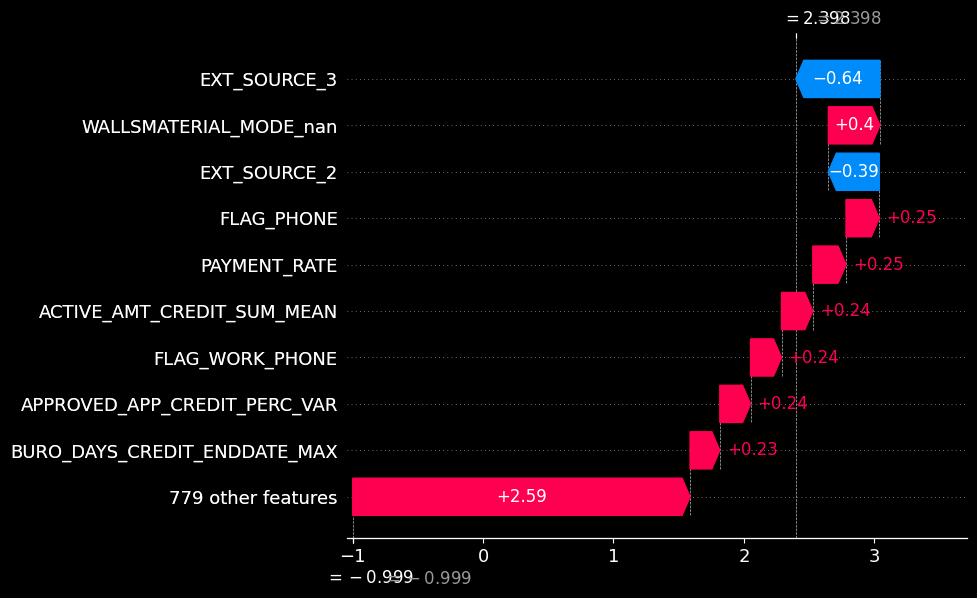

In [26]:
shap.plots._waterfall.waterfall_legacy(
    explainer.expected_value[0],
    shap_values[0][0], 
    feature_names=X.columns
)

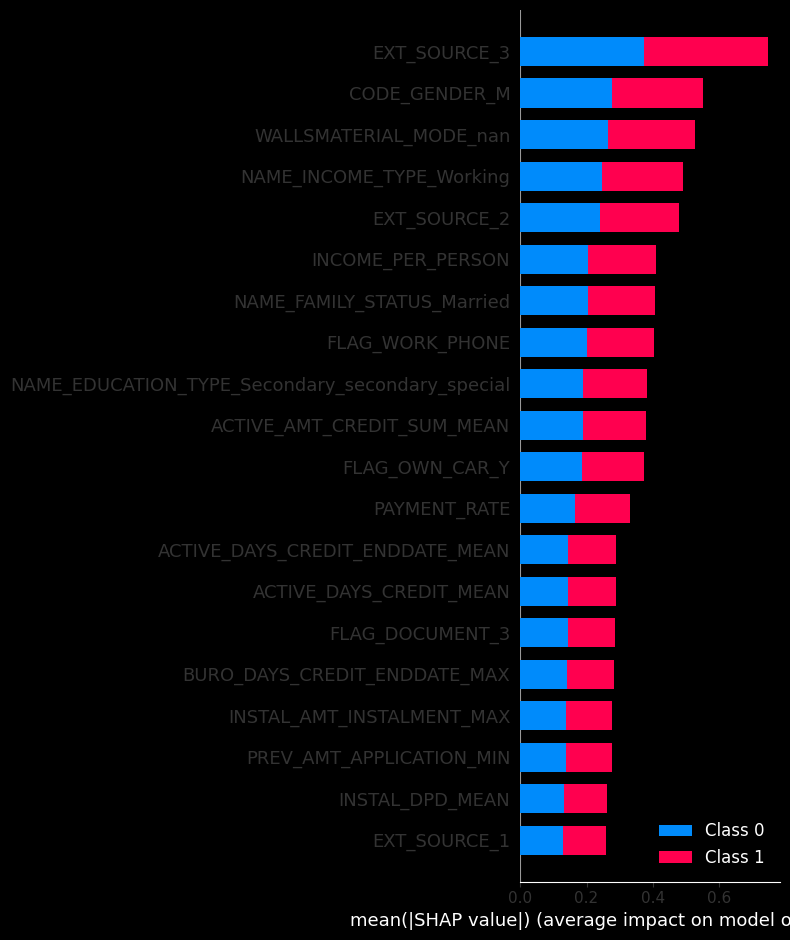

In [27]:
shap.summary_plot(shap_values, features=X)

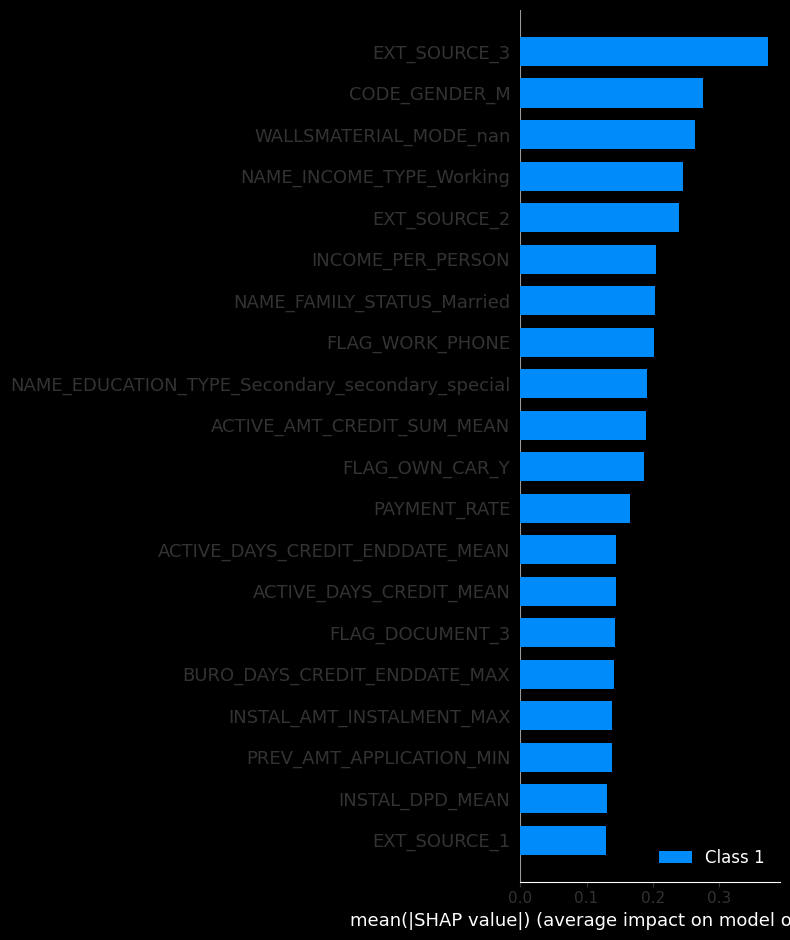

In [29]:
shap.summary_plot(shap_values, features=X, class_inds=[1])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


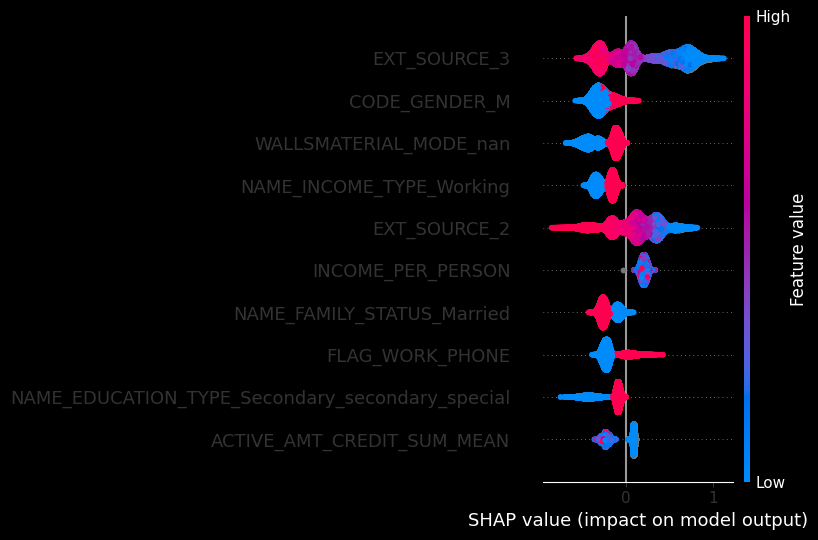

In [30]:
shap.summary_plot(shap_values[1], features=X, max_display=10)

In [32]:
explainer = shap.Explainer(clf, X[y > -1].to_numpy())  # X_train
shap_values = explainer(X[y > -1].to_numpy(), check_additivity=False)  # X_train
shap.plots.bar(shap_values)

AttributeError: 'TreeEnsemble' object has no attribute 'values'

# Choix du meilleur modèle

Nous avons pré-évalué 3 types de modèles, régression logistique, forêt aléatoire et LightGBM, sur la base d'un petit échantillon.

Il s'agit à présent de passer à l'échelle, avec d'une part un échantillon plus important, et une recherche en grille des meilleures configurations.

Il ne s'agit pas seulement de faire jouer les hyper-paramètres de la LGBM, qui est la meilleure candidate pour la haute performance, mais de jouer également sur les paramètres liés à la préparation des données, l'échantillonnage équilibré et la mise à l'échelle des données.

Nous n'utiliserons pas la pipeline de SKL, étant donné que notre fonction `kfold_train_and_eval_model` en est déjà une.

Une recherche en grille va nous permettre de déterminer la meilleure configuration.

# Sérialisation du meilleur modèle

C'est la dernière étape avant de passer à la mise en production du modèle.

Quelle sont les méthodes ?

pickle, etc.

SKL en parle : pickle, le modèle de sérialsiation natif de Python n'est pas idéal.

Voir la section [**Model persistence** (9)](https://scikit-learn.org/stable/model_persistence.html) du manuel d'utilisation.

avantages et inconvénients de chacune d'entre elles ?

Cette section est largement inspirée de la documentation d'utilisation de Scikit-learn.

In [28]:
import os
from pepper.env import get_tmp_dir

tmp_dir = get_tmp_dir()
clf_name = "lgbm_model_baseline"
model_pkl_path = os.path.join(tmp_dir, f"{clf_name}.pkl")

## Pickle et Jolib

Il est possible de sauvegarder un modèle dans scikit-learn en utilisant le modèle de persistance intégré de Python, à savoir [pickle](https://docs.python.org/3/library/pickle.html) :

In [ ]:
import pickle

with open(model_pkl_path, "wb") as f:
    pickle.dump(clf, f)

In [ ]:
import pickle

with open(model_pkl_path, "rb") as f:
    clf2 = pickle.load(f)

y_pred = clf2.predict(X[0:1])
y_true = y[0]

Dans le cas spécifique de scikit-learn, il peut être préférable de subtituer les `dump` & `load` de `joblib` à ceux de `pickle`. `joblib` est plus efficace sur les objets qui comportent de grands tableaux `numpy` en interne, comme c'est souvent le cas pour les estimateurs ajustés de scikit-learn. Inconvénient : il n'est pas possible de *pickler* sur une chaîne, mais seulement de charger depuis le disque

In [ ]:
from joblib import dump, load

model_joblib_path = os.path.join(tmp_dir, f"{clf_name}.joblib")

dump(clf, model_joblib_path)

Le modèle picklé peut être rechargé plus tard (éventuellement dans un autre processus Python) avec :

In [ ]:
dump(clf, model_joblib_path)

**NB** - les fonctions `dump` et `load` acceptent également les objets de type fichier au lieu de noms de fichiers. 

Plus d'informations sur la persistance des données avec [**Joblib**](https://joblib.readthedocs.io/en/latest/persistence.html).

### Limites de sécurité et de maintenabilité

pickle (et joblib par extension), a quelques problèmes concernant la maintenabilité et la sécurité. À cause de cela,
* Ne jamais charger de données non fiables, car cela pourrait entraîner l'exécution d'un code malveillant lors du chargement.
* Bien que les modèles enregistrés à l'aide d'une version de scikit-learn puissent se charger dans d'autres versions, cela n'est absolument pas pris en charge et déconseillé. Il convient également de garder à l'esprit que les opérations effectuées sur ces données pourraient donner des résultats différents et inattendus.

Afin de reconstruire un modèle similaire avec les futures versions de scikit-learn, des métadonnées supplémentaires doivent être enregistrées avec le modèle picklé :
* Les **données d'entraînement**, par ex. une référence à un instantané immuable
* Le **code source Python utilisé pour générer le modèle**
* Les **versions de scikit-learn et ses dépendances**
* Le **score de validation croisée obtenu sur les données d'apprentissage**

Cela devrait permettre de vérifier que le score de validation croisée est dans la même fourchette qu'auparavant.

À quelques exceptions près, les modèles picklés devraient être portables sur toutes les architectures en supposant que les mêmes versions de dépendances et de Python sont utilisées. Si vous rencontrez un estimateur qui n'est pas portable, veuillez ouvrir un problème sur GitHub. Les modèles picklés sont souvent déployés en production à l'aide de conteneurs, comme Docker, afin de figer l'environnement et les dépendances.

Si vous souhaitez en savoir plus sur ces problèmes et explorer d'autres méthodes de sérialisation possibles, veuillez vous reporter à cette [conférence d'Alex Gaynor](https://pyvideo.org/pycon-us-2014/pickles-are-for-delis-not-software.html).

### Un format plus sécurisé : `skops`

[**`skops`**](https://skops.readthedocs.io/en/stable/) fournit un format plus sécurisé via le module [**`skops.io`**](https://skops.readthedocs.io/en/stable/modules/classes.html#module-skops.io). Il évite d'utiliser `pickle` et ne charge que des fichiers ayant des types et des références à des fonctions qui sont considérés comme fiables par défaut ou par l'utilisateur. L'API est très similaire à `pickle`, et vous pouvez persister vos modèles comme expliqué dans la [documentation](https://skops.readthedocs.io/en/stable/persistence.html) en utilisant [`skops.io.dump`](https://skops.readthedocs.io/en/stable/modules/classes.html#skops.io.dump) et [`skops.io.dumps`](https://skops.readthedocs.io/en/stable/modules/classes.html#skops.io.dump).

In [ ]:
import skops.io as sio
obj = sio.dumps(clf)

Les modèles peuvent être rechargés en utilisant [`skops.io.load`](https://skops.readthedocs.io/en/stable/modules/classes.html#skops.io.load) et [`skops.io.loads`](https://skops.readthedocs.io/en/stable/modules/classes.html#skops.io.loads). Il faut néanmoins spécifier les types de données considérés fiables. Les types inconnus existants dans un objet / fichier dumpé peuvent être passés en revue à l'aide de [`skops.io.get_untrusted_types`](https://skops.readthedocs.io/en/stable/modules/classes.html#skops.io.get_untrusted_types), et après cette vérification, l'objet peut être passé à la fonction de chargement.

In [ ]:
unknown_types = sio.get_untrusted_types(obj)
clf = sio.loads(obj, trusted=unknown_types)

Si vous faites confiance à la source du fichier / objet, vous pouvez passer `trusted=True`.

In [ ]:
clf = sio.loads(obj, trusted=True)

## Formats interopérables : [sklearn-onnx](http://onnx.ai/sklearn-onnx/)

Pour des besoins de reproductibilité et de contrôle de la qualité, lorsque différentes architectures et environnements doivent être pris en compte, l'exportation du modèle au format [Open Neural Network Exchange (ONNX)](https://onnx.ai/) ou au format [Predictive Model Markup Language (PMML)](https://dmg.org/pmml/v4-4-1/GeneralStructure.html) peut être une meilleure approche que l'utilisation de pickle seul. Celles-ci sont utiles lorsque vous souhaitez utiliser votre modèle pour la prédiction dans un environnement différent de celui dans lequel le modèle a été formé.

ONNX est une sérialisation binaire du modèle. Il a été développé pour améliorer l'utilisabilité de la représentation interopérable des modèles de données. Il vise à faciliter la conversion des modèles de données entre différents frameworks d'apprentissage automatique, et à améliorer leur portabilité sur différentes architectures informatiques. Plus de détails sont disponibles dans le [tutoriel ONNX](https://onnx.ai/get-started.html). Pour convertir le modèle scikit-learn en ONNX, un outil spécifique [sklearn-onnx](http://onnx.ai/sklearn-onnx/) a été développé.

PMML est une implémentation de la norme de document [XML](https://en.wikipedia.org/wiki/XML) définie pour représenter des modèles de données avec les données utilisées pour les générer. Étant lisible par l'homme et la machine, PMML est une bonne option pour la validation de modèles sur différentes plates-formes et l'archivage à long terme. D'autre part, comme XML en général, sa verbosité n'aide pas en production lorsque les performances sont critiques. Pour convertir le modèle scikit-learn en PMML, vous pouvez utiliser par exemple [sklearn2pmml](https://github.com/jpmml/sklearn2pmml) distribué sous la licence Affero GPLv3.

### Exemple SKL-ONNX

Extrait de http://onnx.ai/sklearn-onnx/

```Python
# Train a model.
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
iris = load_iris()
X, y = iris.data, iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y)
clr = RandomForestClassifier()
clr.fit(X_train, y_train)

# Convert into ONNX format
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
initial_type = [('float_input', FloatTensorType([None, 4]))]
onx = convert_sklearn(clr, initial_types=initial_type)
with open("rf_iris.onnx", "wb") as f:
    f.write(onx.SerializeToString())

# Compute the prediction with ONNX Runtime
import onnxruntime as rt
import numpy
sess = rt.InferenceSession("rf_iris.onnx", providers=["CPUExecutionProvider"])
input_name = sess.get_inputs()[0].name
label_name = sess.get_outputs()[0].name
pred_onx = sess.run([label_name], {input_name: X_test.astype(numpy.float32)})[0]
```